1. Load a binary dataset

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

2. validation split and scaling

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

3. Baseline SVM

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

lin_clf = SVC(kernel="linear", probability=True, random_state=42)
lin_clf.fit(X_train_sc, y_train)

y_pred_lin = lin_clf.predict(X_test_sc)
print("Linear SVM accuracy:", accuracy_score(y_test, y_pred_lin))
print(confusion_matrix(y_test, y_pred_lin))
print(classification_report(y_test, y_pred_lin))

Linear SVM accuracy: 0.9736842105263158
[[41  1]
 [ 2 70]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



4. Non-linear SVM

In [4]:
rbf_clf = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42)
rbf_clf.fit(X_train_sc, y_train)

y_pred_rbf = rbf_clf.predict(X_test_sc)
print("RBF SVM accuracy:", accuracy_score(y_test, y_pred_rbf))
print(confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))

RBF SVM accuracy: 0.9824561403508771
[[41  1]
 [ 1 71]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



5. Visualize decision boundary

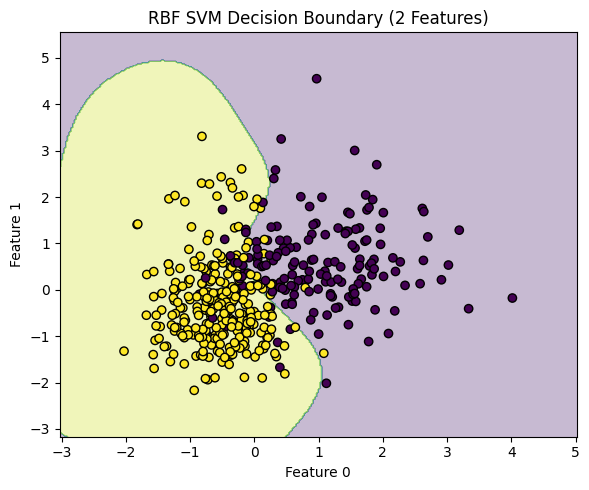

In [6]:
import numpy as np
import matplotlib.pyplot as plt

feat_a, feat_b = 0, 1
X2 = X.iloc[:, [feat_a, feat_b]]
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.2, stratify=y, random_state=42
)

scaler2 = StandardScaler()
X2_train_sc = scaler2.fit_transform(X2_train)
X2_test_sc  = scaler2.transform(X2_test)

clf2 = SVC(kernel="rbf", C=1.0, gamma="scale", probability=False, random_state=42).fit(X2_train_sc, y2_train)

x_min, x_max = X2_train_sc[:,0].min()-1, X2_train_sc[:,0].max()+1
y_min, y_max = X2_train_sc[:,1].min()-1, X2_train_sc[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = clf2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X2_train_sc[:,0], X2_train_sc[:,1], c=y2_train, edgecolor="k")
plt.title("RBF SVM Decision Boundary (2 Features)")
plt.xlabel(f"Feature {feat_a}")
plt.ylabel(f"Feature {feat_b}")
plt.tight_layout()
plt.savefig("plots/decision_boundary_2features.png", dpi=150)
plt.show()


6. Hyperparameter tuning and Cross-validation

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

param_grid = {
    "svc__C":     [0.1, 1, 10, 100],
    "svc__gamma": ["scale", 0.01, 0.1, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (F1):", grid.best_score_)

best_model = grid.best_estimator_
print("Test accuracy:", best_model.score(X_test, y_test))


Best params: {'svc__C': 10, 'svc__gamma': 0.01}
Best CV score (F1): 0.9809869017218904
Test accuracy: 0.9824561403508771


7. Final evaluation & saving artifacts

Test ROC AUC: 0.9976851851851851


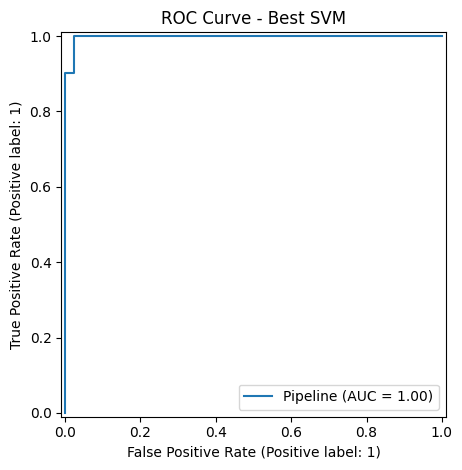

['models/best_svm.joblib']

In [9]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import joblib
import matplotlib.pyplot as plt
import os

y_proba = best_model.predict_proba(X_test)[:,1]
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Best SVM")
plt.tight_layout()

os.makedirs("plots", exist_ok=True)

plt.savefig("plots/roc_best_svm.png", dpi=150)
plt.show()

os.makedirs("models", exist_ok=True)

joblib.dump(best_model, "models/best_svm.joblib")